<a href="https://colab.research.google.com/github/Cezari0o/PLN-Trab/blob/main/projeto_final/%5BPLN%5D_Projeto_Final_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - LSTM
Gabriel Cesário Silva Martins - 180100912 

Training and classifying the dataset with an LSTM model. 

## Loading the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln --symbolic /content/drive/MyDrive/UnB/PLN/projeto_final/ /dir
%cd /dir/.
!ls .

/content/drive/MyDrive/UnB/PLN/projeto_final
LSTM_Classifier		       Mental-Health-Twitter-pre-processed.csv
Mental-Health-Twitter.csv      projeto_final
Mental-Health-Twitter.csv.zip  RNN_Classifier


Some imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding,Bidirectional, Input
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv('Mental-Health-Twitter-pre-processed.csv')
df = df.drop('Unnamed: 0', axis=1)

In [6]:
df.columns

Index(['post_id', 'post_created', 'post_text', 'user_id', 'followers',
       'friends', 'favourites', 'statuses', 'retweets', 'label', 'is_retweet',
       'tweet_num_words'],
      dtype='object')

## Convert the Text for use in the model

Data split. The seed used is the same for all models

In [7]:
random_seed = 168
x_train, x_rest, y_train, y_rest = train_test_split(df['post_text'], df['label'], random_state = random_seed, test_size=0.2, shuffle=True)

In [8]:
x_valid, x_test, y_valid, y_test = train_test_split(x_rest, y_rest, random_state = random_seed, test_size=0.5, shuffle=True)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [10]:
train_sequences = tokenizer.texts_to_sequences(x_train)

Estimating a max size for the vectors used in the network. Later, a sentence embedding will be used 

In [11]:
max_len = 0

for s in train_sequences:
  max_len = len(s) if len(s) > max_len else max_len
print(f"Maximum text size, in words: {max_len}")

Maximum text size, in words: 27


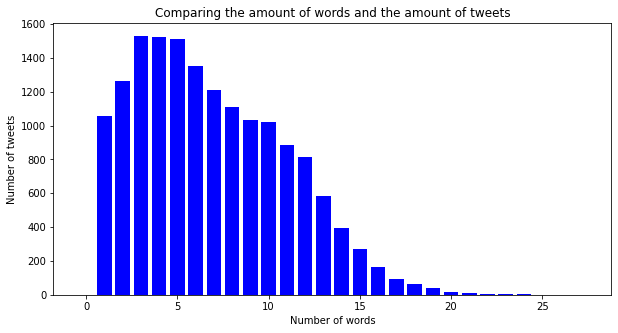

In [12]:
hist = dict()

hist['qt'] = list(range(max_len + 1))

my_list = [0]*(max_len + 1)

for x in train_sequences:
  my_list[len(x)] += 1

hist['num texts'] = my_list

fig = plt.figure(figsize = (10, 5))
 
plt.bar(hist['qt'],hist['num texts'],
        color ='blue')
 
plt.xlabel("Number of words")
plt.ylabel("Number of tweets")
plt.title("Comparing the amount of words and the amount of tweets")
plt.show()

Most tweets are around 15 words long. However, since the number of words in a tweet is small, the maximum size is preserved (thus, there is no loss of information).

In [13]:
max_len = 27
trunc_type = 'post'
padding_type = 'post'
train_padded = pad_sequences(train_sequences, maxlen= max_len, padding=padding_type, truncating=trunc_type)

In [14]:
valid_sequences = tokenizer.texts_to_sequences(x_valid)
test_sequences = tokenizer.texts_to_sequences(x_test)

valid_padded = pad_sequences(valid_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Handling the output

Here, a one-hot enconding is used within the classes.

In [15]:
y_train = pd.Categorical(y_train)
y_train_int = y_train.codes

y_valid = pd.Categorical(y_valid)
y_valid_int = y_valid.codes

y_test = pd.Categorical(y_test)
y_test_int = y_test.codes

In [16]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

## Creating and Training the Network

Defining the model

In [26]:
model = Sequential(layers = [
    Input(shape=[max_len]),
    Embedding(input_dim = len(tokenizer.word_counts), output_dim = 128),
    LSTM(256, return_sequences=True, dropout=0.5),
    LSTM(128, return_sequences=True, dropout=0.5),
    LSTM(64),
    # Dense(128, activation='relu'),
    # Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
], name = 'LSTM_Classifier')

model.summary()

Model: "LSTM_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 27, 128)           2071936   
                                                                 
 lstm_12 (LSTM)              (None, 27, 256)           394240    
                                                                 
 lstm_13 (LSTM)              (None, 27, 128)           197120    
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2,714,850
Trainable params: 2,714,850

Training using a Adam optmizer. 

In [27]:
adam_optimizer = Adam(learning_rate=0.002)
model.compile(loss="categorical_crossentropy",optimizer=adam_optimizer,metrics=['accuracy'])
train_history = model.fit(train_padded, y_train, validation_data=(valid_padded, y_valid), epochs=50, batch_size=32)

Epoch 1/50
499/499 [==============================] - 11s 14ms/step - loss: 0.6805 - accuracy: 0.5615 - val_loss: 0.6927 - val_accuracy: 0.5158
Epoch 2/50
499/499 [==============================] - 6s 12ms/step - loss: 0.6454 - accuracy: 0.6314 - val_loss: 0.6581 - val_accuracy: 0.6407
Epoch 3/50
499/499 [==============================] - 6s 12ms/step - loss: 0.6496 - accuracy: 0.5905 - val_loss: 0.6921 - val_accuracy: 0.4887
Epoch 4/50
499/499 [==============================] - 6s 12ms/step - loss: 0.6916 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5158
Epoch 5/50
499/499 [==============================] - 6s 12ms/step - loss: 0.6624 - accuracy: 0.5732 - val_loss: 0.6138 - val_accuracy: 0.6533
Epoch 6/50
499/499 [==============================] - 6s 12ms/step - loss: 0.5385 - accuracy: 0.7344 - val_loss: 0.6053 - val_accuracy: 0.6724
Epoch 7/50
499/499 [==============================] - 7s 14ms/step - loss: 0.4489 - accuracy: 0.7866 - val_loss: 0.5255 - val_accuracy: 0.736

Plotting the loss training history.

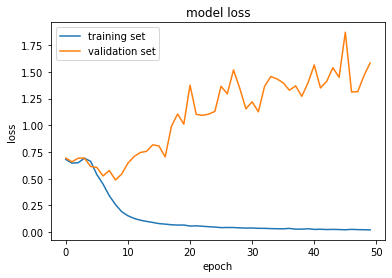

In [28]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

# Testing the Model

In [29]:
y_prob = model.predict(test_padded)
# y_pred = np.argmax(y_prob,axis=1)
y_pred = np.where(y_prob >= 0.5, 1, 0)

In [30]:
print(classification_report(y_test,y_pred, zero_division=0, digits=3))

              precision    recall  f1-score   support

           0      0.779     0.799     0.789      1017
           1      0.785     0.764     0.775       976

   micro avg      0.782     0.782     0.782      1993
   macro avg      0.782     0.782     0.782      1993
weighted avg      0.782     0.782     0.782      1993
 samples avg      0.782     0.782     0.782      1993



## Saving the model

In [ ]:
model.save(filepath='LSTM_Classifier/.')

# Source
Below are some of the fonts used to run this notebook. Parts of them have been adapted here.

- https://github.com/Cezari0o/PLN-Trab/blob/main/a8/A8_PLN.ipynb
- https://www.kaggle.com/code/tmishinev/nlp-depression-tweets-keras-lstm